In [1]:
import torch
import os
import random
import string
from unidecode import unidecode

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"using: {device}")
torch.manual_seed(42)

using: cuda


In [2]:
class NamesDataset(torch.utils.data.Dataset):

    letter_to_int = {c: i for i, c in enumerate(string.ascii_letters[:26] + " ")}
    int_to_letter = {i: c for i, c in enumerate(string.ascii_letters[:26] + " ")}

    def __init__(self, dataset_path: str):
        xy = []
        classes = {}
        max_name_len = 0
        for i, fname in enumerate(os.listdir(dataset_path)):
            classes[i] = os.path.splitext(fname)[0]
            with open(os.path.join(dataset_path, fname), "r", encoding="utf-8") as f:
                for line in f:
                    name = unidecode(line.strip().lower())
                    name = "".join([c for c in name if c in self.letter_to_int])
                    max_name_len = max(max_name_len, len(name))
                    xy.append((name, i))

        random.seed(42)
        random.shuffle(xy)
        
        self.xy = xy
        self.classes = classes
        self.max_name_len = max_name_len

    def __getitem__(self, idx):
        x_str, y_int = self.xy[idx]
        x_str = self.padding(x_str, self.max_name_len)
        x = self.name2tensor(x_str).to(device=device)
        y = torch.zeros(len(self.classes), device=device)
        y[y_int] = 1

        return x, y
    
    def __len__(self):
        return len(self.xy)
    
    @staticmethod
    def padding(x: str, target_len):
        required_padding = target_len - len(x)
        if required_padding:
            # left_pad = random.randint(0, required_padding)
            left_pad = required_padding  # put all paddings to the left
            right_pad = required_padding - left_pad
            x_padded = left_pad * " " + x + right_pad * " "
            assert len(x_padded)==target_len, "padding has gone wrong!"
            return x_padded
        else:
            return x

    @staticmethod
    def name2tensor(name):
        tensor = torch.zeros(len(name), len(NamesDataset.letter_to_int))
        for i, char in enumerate(name):
            if char not in NamesDataset.letter_to_int:
                raise ValueError("'{char}' does not exist in letter_to_int dictionary.")
            tensor[i, NamesDataset.letter_to_int[char]] = 1.0
        return tensor
    
    @staticmethod
    def tensor2name(tensor):
        name = ""
        for row in tensor:
            name += NamesDataset.int_to_letter[row.argmax(-1).item()]
        return name

ds = NamesDataset(dataset_path="../datasets/names-2class/")
ds_loader = torch.utils.data.DataLoader(ds, batch_size=128, shuffle=False)

In [3]:
class RNNExtractor(torch.nn.Module):
    def forward(self, X):
        return X[0]

class NameEncoder(torch.nn.Module):
    def __init__(self, seq_len, feat_len, latent_dim):
        super().__init__()
        seq_len = seq_len
        feat_len = feat_len
        hidden_size = 256
        num_layers = 1

        self.base_layers = torch.nn.Sequential(
            torch.nn.RNN(feat_len, hidden_size, num_layers, batch_first=True),
            RNNExtractor(),
            torch.nn.ReLU(),

            # torch.nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True),
            # RNNExtractor(),
            # torch.nn.ReLU(),

            # torch.nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True),
            # RNNExtractor(),
            # torch.nn.ReLU(),            

            torch.nn.Flatten(start_dim=1),
            torch.nn.Linear(hidden_size*seq_len, hidden_size),
            torch.nn.ReLU(),
        )
        self.mu_layer = torch.nn.Linear(hidden_size, latent_dim)
        self.sigma_layer = torch.nn.Linear(hidden_size, latent_dim)

    def forward(self, X):
        out = self.base_layers(X)

        mu = self.mu_layer(out)
        sigma = self.sigma_layer(out)

        std = torch.exp(0.5 * sigma)
        eps = torch.randn_like(std)
        z = mu + eps * std
        
        return mu, sigma, z

class NameDecoder(torch.nn.Module):
    def __init__(self, seq_len, feat_len, latent_dim):
        super().__init__()
        seq_len = seq_len
        feat_len = feat_len
        hidden_size = 256
        num_layers = 1

        self.base_layers = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_size),
            torch.nn.ReLU(),

            torch.nn.Linear(hidden_size, hidden_size*seq_len),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (seq_len, hidden_size)),
            
            # torch.nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True),
            # RNNExtractor(),
            # torch.nn.ReLU(),

            # torch.nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True),
            # RNNExtractor(),
            # torch.nn.ReLU(),

            torch.nn.RNN(hidden_size, feat_len, num_layers, batch_first=True),
            RNNExtractor(),

            torch.nn.Softmax(-1),
        )

    def forward(self, X):
        out = self.base_layers(X)        
        return out

class VAE(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, X):
        mu, sigma, z = self.encoder(X)
        reconstructed_X = self.decoder(z)
        return reconstructed_X, mu, sigma

In [4]:
en = NameEncoder(14, 27, 2).to(device)
de = NameDecoder(14, 27, 2).to(device)
vae = VAE(en, de)

In [5]:
x, y = next(iter(ds_loader))
with torch.no_grad():
    print("input: ", x.shape)
    mu, sigma, z = en(x)
    print("encoder mu: ", mu.shape)
    print("encoder sigma: ", sigma.shape)
    print("encoder z: ", z.shape)
    print("decoded: ", de(z).shape)

input:  torch.Size([128, 14, 27])
encoder mu:  torch.Size([128, 2])
encoder sigma:  torch.Size([128, 2])
encoder z:  torch.Size([128, 2])
decoded:  torch.Size([128, 14, 27])


In [6]:
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

def lossfn(reconstructed_x, x, mu, sigma):
    BCE = torch.nn.BCELoss()(reconstructed_x, x)
    KLD = -5e-4 * torch.mean(1 + sigma - mu.pow(2) - sigma.exp())
    return torch.mean(BCE + KLD)

def train_one_batch(X):
    """
    do one step training.
    Args:
        X (Tensor): input tensors.

    Returns:
        float: loss value.
    """
    optimizer.zero_grad()
    reconstructed_X, mu, sigma = vae(X)
    loss = lossfn(reconstructed_X, X, mu, sigma)
    loss.backward()
    optimizer.step()
    return loss.item()

In [7]:
n_epochs = 100
print("epoch\t\tbatch\t\ttraining loss")
print("----------------------------------------------")
train_loss = []
for epoch in range(n_epochs):
    train_loss.append(0)
    ibatch = 0
    all_batches = len(ds_loader)
    for X, Y in ds_loader:
        ibatch += 1
        train_loss[-1] += train_one_batch(X.to(device))
        print(f"{epoch+1}\t\t{ibatch}/{all_batches}\t\t{train_loss[-1]/all_batches:.5f}", end="\r")
    train_loss[-1] /= all_batches
    print()

epoch		batch		training loss
----------------------------------------------
1		37/37		0.12101
2		37/37		0.11517
3		37/37		0.11361
4		37/37		0.11235
5		37/37		0.11161
6		37/37		0.11108
7		37/37		0.11050
8		37/37		0.11007
9		37/37		0.10967
10		37/37		0.10939
11		37/37		0.10902
12		37/37		0.10889
13		37/37		0.10867
14		37/37		0.10853
15		37/37		0.10843
16		37/37		0.10838
17		37/37		0.10820
18		37/37		0.10825
19		37/37		0.10815
20		37/37		0.10806
21		37/37		0.10791
22		37/37		0.10778
23		37/37		0.10773
24		37/37		0.10777
25		37/37		0.10777
26		37/37		0.10762
27		37/37		0.10753
28		37/37		0.10753
29		37/37		0.10744
30		37/37		0.10742
31		37/37		0.10736
32		37/37		0.10730
33		37/37		0.10724
34		37/37		0.10726
35		37/37		0.10721
36		37/37		0.10717
37		37/37		0.10711
38		37/37		0.10710
39		37/37		0.10702
40		37/37		0.10703
41		37/37		0.10699
42		37/37		0.10692
43		37/37		0.10692
44		37/37		0.10696
45		37/37		0.10687
46		37/37		0.10683
47		37/37		0.10682
48		37/37		0.10684
49		37/37		0.10677
50	

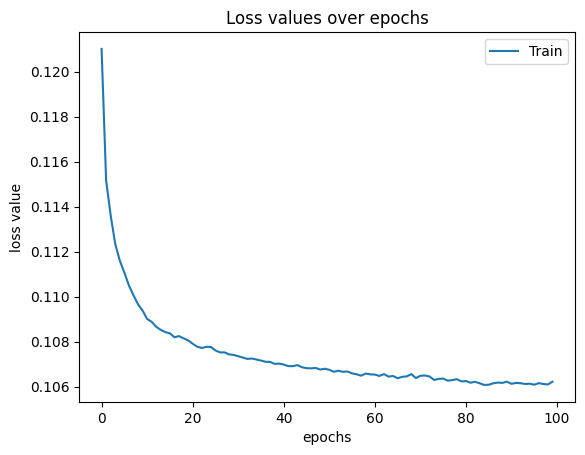

In [8]:
import matplotlib.pyplot as plt
plt.plot(range(n_epochs), train_loss)
plt.title("Loss values over epochs")
plt.xlabel("epochs")
plt.ylabel("loss value")
plt.legend(["Train"])
plt.show()

In [15]:
import pandas as pd
x, y = next(iter(ds_loader))
with torch.no_grad():
    output, _, _ = vae(x)
df = {"input":[], "reconstructed input":[]}
for i in range(20):
    x_str = ds.tensor2name(x[i, ...])
    output_str = ds.tensor2name(output[i, ...])
    df["input"].append(x_str.strip())
    df["reconstructed input"].append(output_str.strip())

df = pd.DataFrame(df)
df = df.style.set_properties(**{'text-align': 'center'})
df


,input,reconstructed input
0,kido,hale
1,makuda,kakaka
2,amos,alen
3,ratcliffe,kalge
4,plant,kant
5,ilsley,arilan
6,utagawa,katami
7,pendleton,ralan
8,normington,anisan
9,allcock,llrand


In [10]:
Z = []
Y = []
with torch.no_grad():
    for x, y in ds_loader:
        Z.append(en(x)[2])
        Y.append(y.argmax(-1))
Z = torch.concat(Z, dim=0).to("cpu").numpy()
Y = torch.concat(Y, dim=0).to("cpu").numpy()        

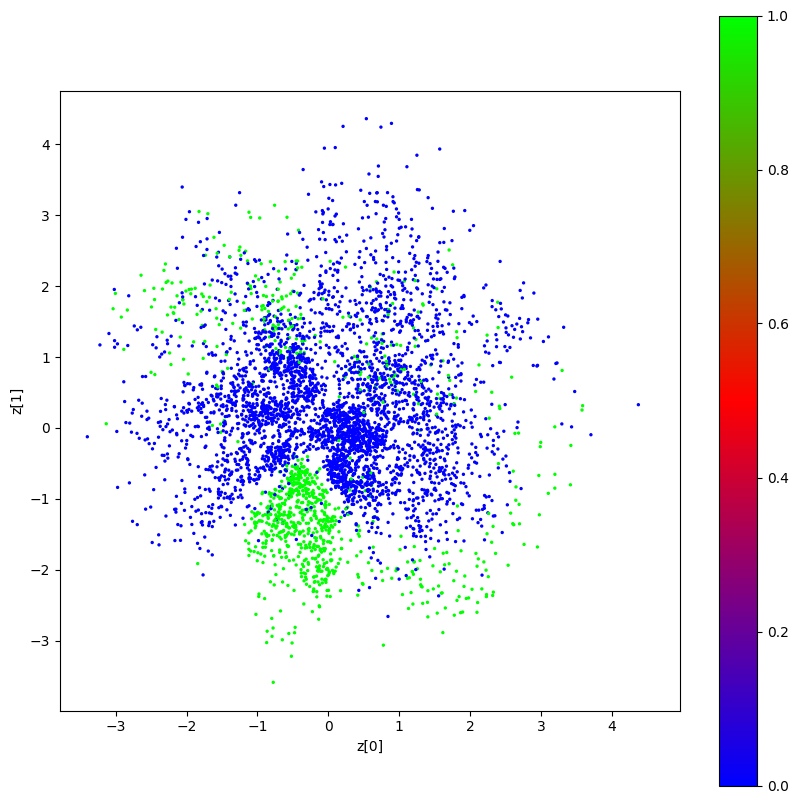

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
axs = fig.add_subplot(111)

s = axs.scatter(Z[:, 0], Z[:, 1], c=Y, cmap='brg', s=2)
axs.set_xlabel('z[0]')
axs.set_ylabel('z[1]')
plt.colorbar(s)
axs.axis('square')
plt.show()